In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense
from tensorflow.random import set_seed
from sklearn.metrics import mean_squared_error

df_raw = pd.read_csv("Steel_industry_data.csv", sep=',')
df = df_raw.copy()
print(df.shape)
df

(35040, 11)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [54]:
# Масштабирование
scaler = MinMaxScaler()
series = df['Usage_kWh'].values.reshape(-1, 1)
scaled = scaler.fit_transform(series)

# Создание последовательностей
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, seq_len=60)
# Разбиение
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Установка семени для воспроизводимости
set_seed(42)


In [55]:
def build_rnn():
    model = Sequential([
        SimpleRNN(50, input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru():
    model = Sequential([
        GRU(50, input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm():
    model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Обучение и оценка моделей
models = {'RNN': build_rnn(), 'GRU': build_gru(), 'LSTM': build_lstm()}
histories = {}
mse_results = {}
for name, model in models.items():
    print(f"Training {name}...")
    hist = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    histories[name] = hist
    # Прогноз и MSE
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    mse_results[name] = mse
    print(f"{name} Test MSE: {mse:.6f}\n")

# Сравнение результатов
print("Model comparison (MSE):")
for name, mse in mse_results.items():
    print(f"{name}: {mse:.6f}")



C:\Users\User\PycharmProjects\TPNS4\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
Epoch 1/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.1824 - val_loss: 0.1091
Epoch 2/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.1561 - val_loss: 0.1023
Epoch 3/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1497 - val_loss: 0.0965
Epoch 4/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1412 - val_loss: 0.0913
Epoch 5/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.1353 - val_loss: 0.0892
Epoch 6/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.1328 - val_loss: 0.0879
Epoch 7/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1326 - val_loss: 0.0859
Epoch 8/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1270 - val_loss: 0.0852
Epoch 9/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1220 - val_loss: 0.0842
Epoch 10/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1214 - val_loss: 0.0821
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
RNN Test MSE: 0.080635

Training GRU...
Epoch 1/10
788/788 ━━━

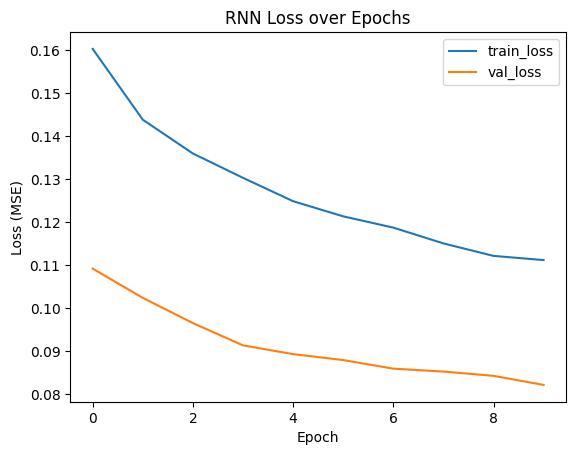

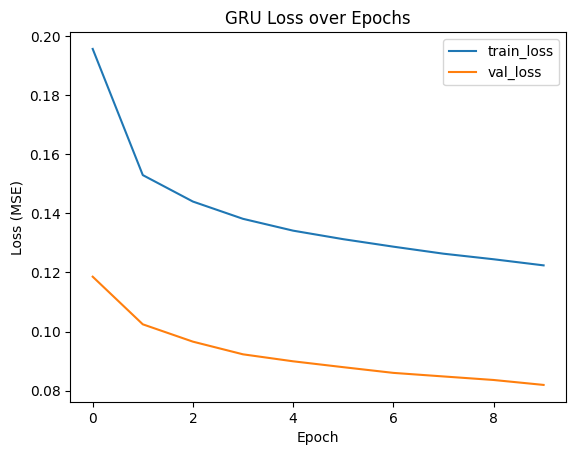

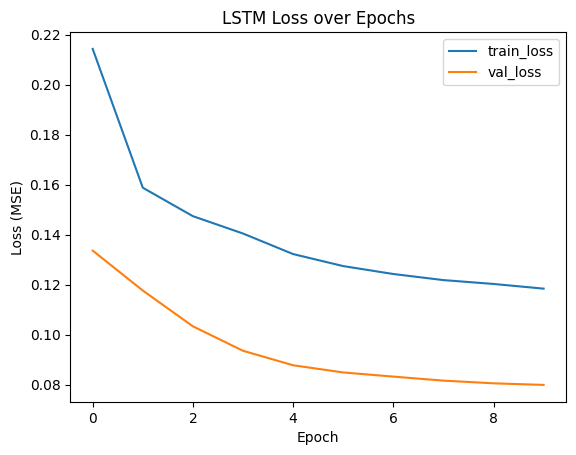

In [56]:
# Визуализация потерь
import matplotlib.pyplot as plt
for name, hist in histories.items():
    plt.figure()
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{name} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()